In [8]:
import os

# Set environment variables to disable multithreading as users will probably
# want to set the number of cores to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
###############################################################################
# Set TensorFlow print of log information
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [9]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from anomaly.constants import GALAXY_LINES
from anomaly.utils import specobjid_to_idx
from sdss.metadata import MetaData
from autoencoders.ae import AutoEncoder

meta = MetaData()
%matplotlib inline

In [19]:
bin_id = "bin_03"
model_id = "0008"
architecture = "256_128_64/latent_12"

meta_data_directory = "/home/edgar/spectra/0_01_z_0_5_4_0_snr_inf"
scores_directory = (
    f"{meta_data_directory}/{bin_id}/explanation/256_128_64/latent_12"
)
model_directory = f"{meta_data_directory}/{bin_id}/models/{architecture}"

wave = np.load(f"{meta_data_directory}/wave.npy")
spectra = np.load(f"{meta_data_directory}/spectra.npy", mmap_mode="r")
ids = np.load(f"{meta_data_directory}/ids_inputting.npy")

model = AutoEncoder(reload=True, reload_from=f"{model_directory}/{model_id}")

In [11]:
def plot_compare():
    fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, tight_layout=True)

    axs[1, 0].set_xlabel("$\lambda [\AA]$")
    axs[1, 1].set_xlabel("$\lambda [\AA]$")
    axs[0, 0].set_ylabel("Median normalized flux")
    axs[1, 0].set_ylabel("Residual")

    return fig, axs


def plot_residual():
    fig, axs = plt.subplots(
        nrows=2,
        ncols=1,
        # figsize=(20,12),
        sharex=True,
        tight_layout=True,
    )

    axs[0].set_ylabel("Median normalized flux")
    axs[1].set_ylabel("Residual")
    axs[1].set_xlabel("$\lambda [\AA]$")

    return fig, axs


def compare(spectra_idx):
    observation = spectra[spectra_idx]
    reconstruction = model.reconstruct(observation).reshape(-1)
    residual = np.abs(observation - reconstruction)

    return observation, reconstruction, residual

In [12]:
## Get sets of specobjids of anomalous spectra per score
scores_names = {
    "mse_noRel100": "MSE score",
    "mse_filter_250kms_noRel100": "MSE score with a 250 kms filter",
    "mse_noRel97": "MSE score ignoring 3% of largest residuals",
    "mse_filter_250kms_noRel97": "MSE score ignoring 3% of largest residuals with a 250 kms filter",
    "mse_rel100": "MSE relative score",
    "mse_filter_250kms_rel100": "MSE relative score with a 250 kms filter",
    "mse_rel97": "MSE relative score\n ignoring 3% of largest residuals",
    "mse_filter_250kms_rel97": "MSE relative score ignoring 3% of largest residuals with a 250 kms filter",
}

In [13]:
df_scores = {}

for score_name in scores_names.keys():

    df_scores[score_name] = pd.read_csv(
        f"{scores_directory}/{score_name}/top_anomalies.csv.gz",
        index_col="specobjid",
    )

Save anomalies

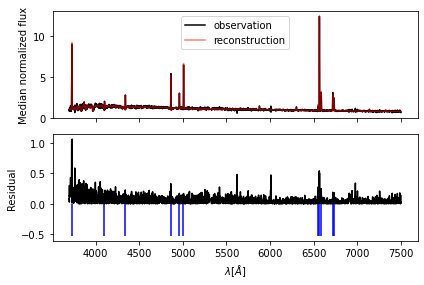

In [14]:
image_format = "pdf"

show_lines = True
fig, axs = plot_residual()

for score in scores_names.keys():
    save_to = f"/home/edgar/Downloads/score/{score}"

    if os.path.exists(save_to) is False:
        os.makedirs(save_to)

    for rank in range(1, 501):

        specobjid = df_scores[score].index[-rank]
        idx = specobjid_to_idx(specobjid, ids)

        observation, reconstruction, residual = compare(idx)
        for ax in axs:
            ax.clear()
        axs[0].set_ylabel("Median normalized flux")
        axs[1].set_ylabel("Residual")
        axs[1].set_xlabel("$\lambda [\AA]$")

        axs[0].plot(wave, observation, c="black", label="observation")
        axs[0].plot(
            wave, reconstruction, c="red", label="reconstruction", alpha=0.5
        )
        axs[1].plot(wave, residual, c="black")

        axs[0].legend()

        if show_lines is True:
            for line in GALAXY_LINES:
                axs[1].vlines(
                    GALAXY_LINES[line],
                    ymin=0,
                    ymax=-residual.max() * 0.5,
                    color="blue",
                )

        fig.savefig(f"{save_to}/rank_{rank:03d}.{image_format}")

Save normal spectra 

In [15]:
df_normal_scores = {}

for score_name in scores_names.keys():

    df_normal_scores[score_name] = pd.read_csv(
        f"{scores_directory}/{score_name}/top_normal.csv.gz",
        index_col="specobjid",
    )

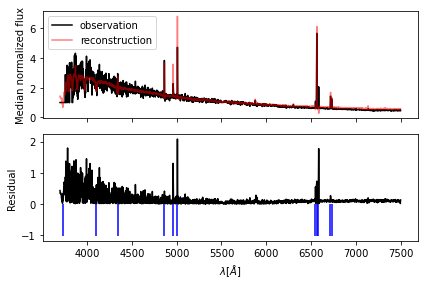

In [18]:
image_format = "pdf"

show_lines = True
fig, axs = plot_residual()

for score in scores_names.keys():
    save_to = f"/home/edgar/Downloads/bin_04/normal/{score}"

    if os.path.exists(save_to) is False:
        os.makedirs(save_to)

    for rank in range(0, 101):

        specobjid = df_normal_scores[score].index[-rank]
        idx = specobjid_to_idx(specobjid, ids)

        observation, reconstruction, residual = compare(idx)
        for ax in axs:
            ax.clear()
        axs[0].set_ylabel("Median normalized flux")
        axs[1].set_ylabel("Residual")
        axs[1].set_xlabel("$\lambda [\AA]$")

        axs[0].plot(wave, observation, c="black", label="observation")
        axs[0].plot(
            wave, reconstruction, c="red", label="reconstruction", alpha=0.5
        )
        axs[1].plot(wave, residual, c="black")

        axs[0].legend()

        if show_lines is True:
            for line in GALAXY_LINES:
                axs[1].vlines(
                    GALAXY_LINES[line],
                    ymin=0,
                    ymax=-residual.max() * 0.5,
                    color="blue",
                )

        fig.savefig(f"{save_to}/rank_{rank:03d}.{image_format}")